# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 7th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "robert"
ln1 = "gower"
fn2 = "alexandre"
ln2 = "gramfort"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_gower_robert_and_gramfort_alexandre.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5,1,'Parameters / Coefficients')

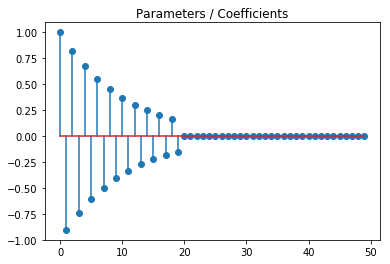

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

/home/alexis/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [6]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""
    return [y-s if y>s else y+s if y<-s else 0 for y in x]
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    
    return s*sum([abs(y) for y in x])

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x""" 
    
    return [y/(s+1) for y in x]
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return (s*0.5)*sum([y**2 for y in x])

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

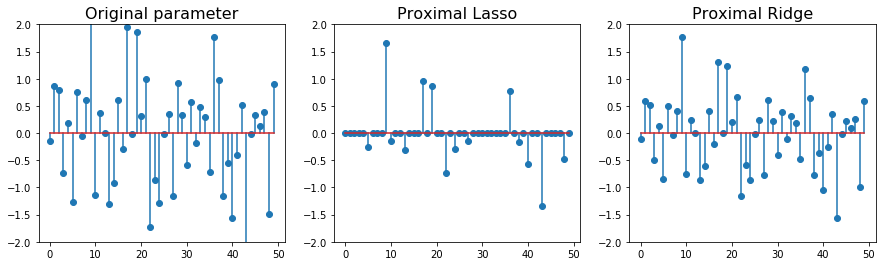

In [7]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [8]:
import scipy
def loss_linreg(x):
    """Least-squares loss"""
    n = n_samples
    f = 1. / (2. * n) * sum((b - np.dot(A, x)) ** 2)
    return f


def grad_linreg(x):
    """Leas-squares gradient"""
    n = n_samples
    grad = 1. / n * np.dot(A.T, np.dot(A, x) - b)
    return grad


def loss_logreg(x):
    """Logistic loss"""
    n = n_samples
    f = 1. / n * sum(np.log1p(np.exp(- b * np.dot(A, x))))
    return f


def grad_logreg(x):
    """Logistic gradient"""
    n = n_samples
    res = 1. / n * (- b * np.exp(-b * np.dot(A, x))) / (
        1 + np.exp(- b * np.dot(A, x)))
    return (np.dot(res, A))

In [9]:
from scipy.optimize import check_grad
A,b = simu_linreg(coefs)
n = len(A[0])
check_grad(loss_linreg,grad_linreg,randn(n))

/home/alexis/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/alexis/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


2.5040871551699088e-05

In [10]:
A,b = simu_logreg(coefs)
n = len(A[0])
check_grad(loss_logreg,grad_logreg,randn(n))

1.4971133384211513e-06

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [11]:
# TO BE COMPLETED

def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    return (1/n)*np.linalg.norm(A,2)**2
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""  
    n = A.shape[0]
    result = (1 / n) * sum((b[i] ** 2) * (np.linalg.norm(A[i, :], 2) ** 2)  for i in range(n))
    return result
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        #### TODO ####
        x = prox_g(x - step*grad_f(x),step*s)
        ##############
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        #obj = abs(obj-t)/t
        objectives.append(obj)
        if k % int((n_iter+1)/2) == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [12]:
# TO BE COMPLETED

def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        new_x = prox_g(z - step*grad_f(z),step*s)
        t_new = (1+(1+4*(t**2))**0.5)*0.5
        z = [new+((t-1)/t_new)*(new-past) for new,past in zip(new_x,x)]
        t = t_new
        x = new_x
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        #obj = abs(obj-minimizer)/minimizer
        objectives.append(obj)
        if k % int((n_iter+1)/2) == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [13]:
# Some definitions before launching the algorithms
x0 = randn(50)
n_iter = 1000
s = 1e-2

In [14]:
print(1/lip_linreg(A))
print(1/lip_logreg(A))

0.014424378712995805
0.019625737252766007


Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.00e+01 | 2.85e+00
     500 | 5.20e-01 | 2.04e-01
    1000 | 4.99e-01 | 1.13e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.00e+01 | 2.85e+00
     500 | 4.99e-01 | 1.10e-01
    1000 | 4.99e-01 | 1.10e-01


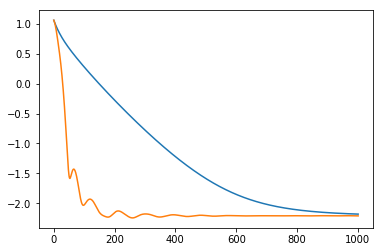

In [15]:
from numpy.linalg import norm
A,b = simu_linreg(coefs)
f = loss_linreg
grad_f = grad_linreg
g = ridge
prox_g = prox_ridge
step = 1/lip_linreg(A)
n = len(A[0])
_,obj,err = ista(x0, f, grad_f, g, prox_g, step, s=s, n_iter=n_iter,x_true=coefs, verbose=True)
plt.plot([np.log(o) for o in err])
x_min,obj,err = fista(x0, f, grad_f, g, prox_g, step, s=s, n_iter=n_iter,x_true=coefs, verbose=True)
plt.plot([np.log(o) for o in err])


<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.14e+01 | 3.55e+00
     500 | 4.99e-01 | 1.11e-01
    1000 | 4.99e-01 | 1.10e-01


<StemContainer object of 3 artists>

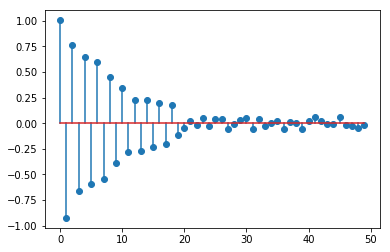

In [18]:
from numpy.linalg import norm
# Some definitions before launching the algorithms
x0 = randn(50)
n_iter = 100
s = 1e-2
EPSILON = 10**-50
f = loss_linreg
grad_f = grad_linreg
g = ridge
prox_g = prox_ridge
step = 1/lip_linreg(A)
t = f(coefs) + g(coefs, s)
t
n = len(A[0])
F_x,F_objectives,f_errors = fista(x0, f, grad_f, g, prox_g, step=step, s=s, n_iter=1000)
minimum = F_objectives[-1]
minimizer = np.asarray(F_x)
x_min = minimizer
plt.stem(F_x)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.01e+01 | 3.50e+00
     100 | 3.08e+00 | 1.58e+00
     200 | 1.23e+00 | 9.02e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.01e+01 | 3.50e+00
     100 | 4.83e-01 | 9.91e-02
     200 | 4.73e-01 | 3.65e-02


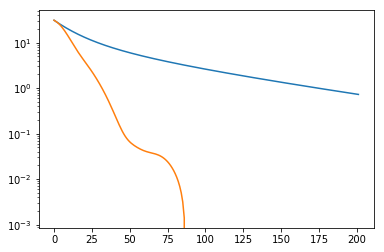

In [19]:
from numpy.linalg import norm
# Some definitions before launching the algorithms
x0 = randn(50)
n_iter = 200
s = 1e-4
EPSILON = 10**-50
f = loss_linreg
grad_f = grad_linreg
g = ridge
prox_g = prox_ridge
step = 1/lip_linreg(A)
t = f(coefs) + g(coefs, s)
t
n = len(A[0])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
_,obj,err = ista(x0, f, grad_f, g, prox_g, step, s=s, n_iter=n_iter,x_true=x_min, verbose=True)
plt.plot([(o-minimum) for o in obj])
_,obj,err = fista(x0, f, grad_f, g, prox_g, step, s=s, n_iter=n_iter,x_true=x_min, verbose=True)
plt.plot([(o-minimum) for o in obj])

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.30e+01 | 3.43e+00
     100 | 5.48e-01 | 2.25e-01
     200 | 4.73e-01 | 1.48e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.30e+01 | 3.43e+00
     100 | 4.73e-01 | 1.51e-01
     200 | 4.72e-01 | 1.50e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.30e+01 | 3.45e+00
     100 | 7.28e-01 | 3.73e-01
     200 | 4.94e-01 | 1.48e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.30e+01 | 3.45e+00
     100 | 4.89e-01 | 1.50e-01
     200 | 4.88e-01 | 1.47e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.28e+01 | 3.50e+00
     100 | 2.82e+00 | 1.38e+00
     200 | 1.06e+00 | 7.20e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.28e+01 | 3.50e+00
     100 | 4.97e-01 | 1.61e-01
     200 | 4.89e-01 | 1.53e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.73e+01 | 3.54e+00
     100 | 5.72e+00 | 2

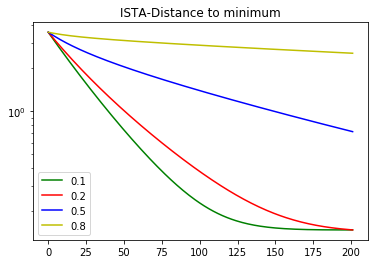

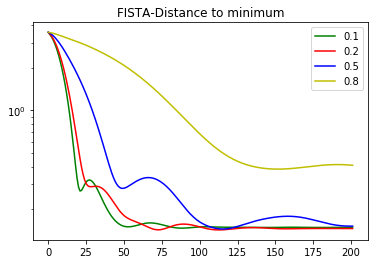

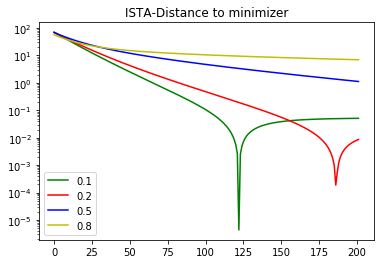

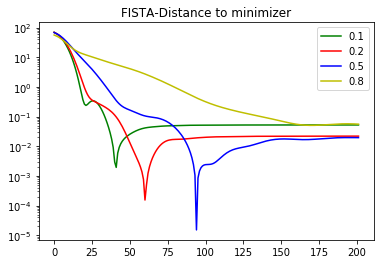

In [23]:
corrs = [0.1,0.2, 0.5, 0.8]
colors = "grby"
for i, corr in enumerate(corrs):
    s = 1e-4
    A,b = simu_linreg(coefs,corr=corr)
    f = loss_linreg
    grad_f = grad_linreg
    g = ridge
    prox_g = prox_ridge
    step = 1/lip_linreg(A)
    i_x,i_objectives,i_errors = ista(x0, f, grad_f, g, prox_g, step, s=s,x_true=x_min, n_iter=n_iter)
    f_x,f_objectives,f_errors = fista(x0, f, grad_f, g, prox_g, step, s=s,x_true=x_min, n_iter=n_iter)
    l = [norm(i_objective - F_objectives[-1])/norm(F_objectives[-1]) for i_objective in i_objectives]
    m = [norm(f_objective - F_objectives[-1])/norm(F_objectives[-1]) for f_objective in f_objectives]
    plt.figure(1)
    plt.plot(i_errors,colors[i],label=str(corr))
    plt.figure(2)
    plt.plot(f_errors,colors[i],label=str(corr))
    plt.figure(3)
    plt.plot(l,colors[i],label=str(corr))
    plt.figure(4)
    plt.plot(m,colors[i],label=str(corr))
    
for fig,name in enumerate(["ISTA-Distance to minimum","FISTA-Distance to minimum","ISTA-Distance to minimizer","FISTA-Distance to minimizer"]):
    plt.figure(fig+1)
    plt.legend()
    plt.title(name)
    plt.yscale('log')

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.49e+00 | 3.55e+00
     100 | 2.98e+00 | 3.15e+00
     200 | 2.50e+00 | 2.76e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.49e+00 | 3.55e+00
     100 | 4.88e-01 | 7.72e-01
     200 | 4.39e-01 | 6.08e-01
2.6261422634124756
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.20e+00 | 3.55e+00
     100 | 2.70e+00 | 3.20e+00
     200 | 2.28e+00 | 2.87e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.20e+00 | 3.55e+00
     100 | 5.83e-01 | 7.01e-01
     200 | 5.27e-01 | 6.36e-01
2.3068933486938477
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.96e+00 | 3.55e+00
     100 | 2.12e+00 | 3.28e+00
     200 | 1.70e+00 | 3.07e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.96e+00 | 3.55e+00
     100 | 8.27e-01 | 1.60e+00
     200 | 6.00e-01 | 7.24e-01
2.3544299602508545


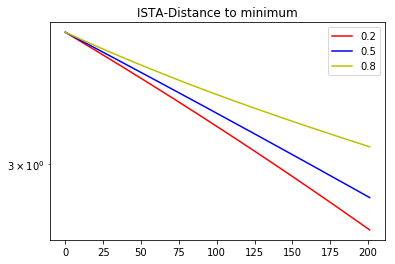

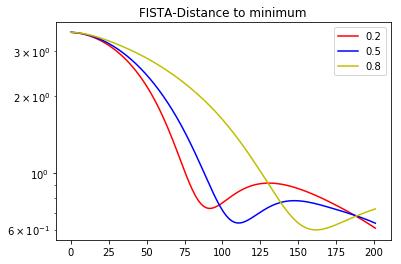

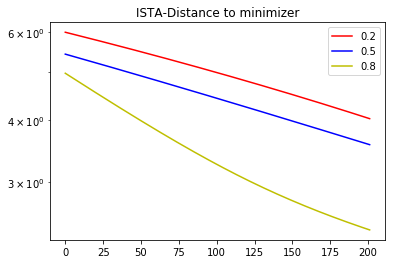

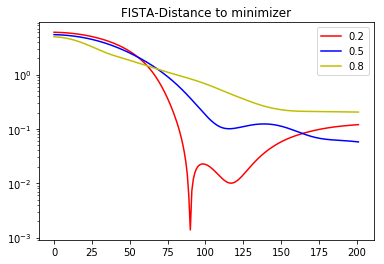

In [24]:
import time
corrs = [0.2, 0.5, 0.8]
colors = "rby"
for i, corr in enumerate(corrs):
    s = 1e-4
    start = time.time()
    A,b = simu_logreg(coefs,corr=corr)
    f = loss_logreg
    grad_f = grad_logreg
    g = ridge
    prox_g = prox_ridge
    step = 1/lip_logreg(A)
    i_x,i_objectives,i_errors = ista(x0, f, grad_f, g, prox_g, step, s=s,x_true=x_min, n_iter=n_iter)
    f_x,f_objectives,f_errors = fista(x0, f, grad_f, g, prox_g, step, s=s,x_true=x_min, n_iter=n_iter)
    l = [norm(i_objective - F_objectives[-1])/norm(F_objectives[-1]) for i_objective in i_objectives]
    m = [norm(f_objective - F_objectives[-1])/norm(F_objectives[-1]) for f_objective in f_objectives]
    plt.figure(1)
    plt.plot(i_errors,colors[i],label=str(corr))
    plt.figure(2)
    plt.plot(f_errors,colors[i],label=str(corr))
    plt.figure(3)
    plt.plot(l,colors[i],label=str(corr))
    plt.figure(4)
    plt.plot(m,colors[i],label=str(corr))
    end = time.time()
    print(end-start)
for fig,name in enumerate(["ISTA-Distance to minimum","FISTA-Distance to minimum","ISTA-Distance to minimizer","FISTA-Distance to minimizer"]):
    plt.figure(fig+1)
    plt.legend()
    plt.title(name)
    plt.yscale('log')

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 5.50e+01 | 3.52e+00
     100 | 7.59e+00 | 1.79e+00
     200 | 2.29e+00 | 1.20e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.50e+01 | 3.52e+00
     100 | 8.53e-01 | 9.13e-01
     200 | 8.04e-01 | 8.85e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.08e+01 | 3.54e+00
     100 | 6.72e+00 | 2.72e+00
     200 | 4.30e+00 | 2.29e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.08e+01 | 3.54e+00
     100 | 6.91e-01 | 4.96e-01
     200 | 6.42e-01 | 4.55e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.85e+01 | 3.54e+00
     100 | 5.93e+00 | 2.88e+00
     200 | 3.92e+00 | 2.54e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.85e+01 | 3.54e+00
     100 | 6.15e-01 | 8.45e-01
     200 | 4.56e-01 | 3.00e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.52e+01 | 3.54e+00
     100 | 5.02e+00 | 2

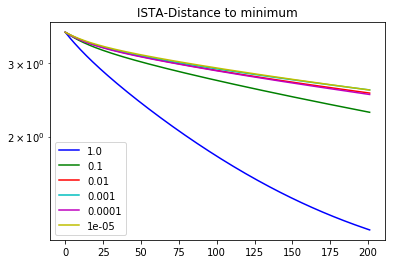

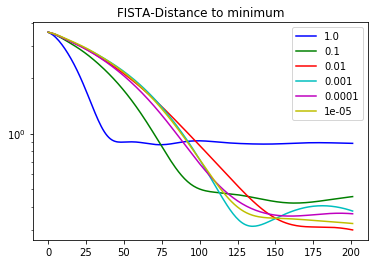

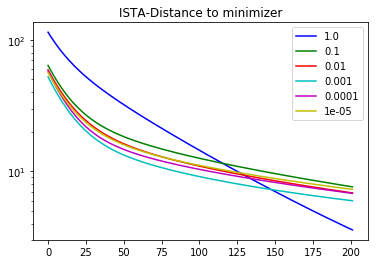

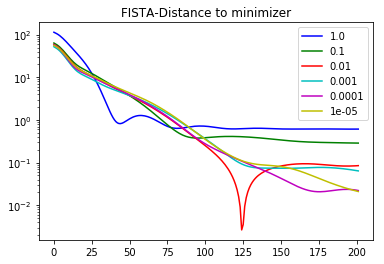

In [25]:
ss = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
colors = "bgrcmyk"
for i, s in enumerate(ss):
    A,b = simu_linreg(coefs,corr=corr)
    f = loss_linreg
    grad_f = grad_linreg
    g = ridge
    prox_g = prox_ridge
    step = 1/lip_linreg(A)
    i_x,i_objectives,i_errors = ista(x0, f, grad_f, g, prox_g, step, s=s,x_true=x_min, n_iter=n_iter)
    f_x,f_objectives,f_errors = fista(x0, f, grad_f, g, prox_g, step, s=s,x_true=x_min, n_iter=n_iter)
    l = [norm(i_objective - F_objectives[-1])/norm(F_objectives[-1]) for i_objective in i_objectives]
    m = [norm(f_objective - F_objectives[-1])/norm(F_objectives[-1]) for f_objective in f_objectives]
    plt.figure(1)
    plt.plot(i_errors,colors[i],label=str(s))
    plt.figure(2)
    plt.plot(f_errors,colors[i],label=str(s))
    plt.figure(3)
    plt.plot(l,colors[i],label=str(s))
    plt.figure(4)
    plt.plot(m,colors[i],label=str(s))
    

for fig,name in enumerate(["ISTA-Distance to minimum","FISTA-Distance to minimum","ISTA-Distance to minimizer","FISTA-Distance to minimizer"]):
    plt.figure(fig+1)
    plt.legend()
    plt.title(name)
    plt.yscale('log')

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.12e+01 | 3.49e+00
     100 | 1.10e+00 | 1.07e+00
     200 | 6.90e-01 | 9.79e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.12e+01 | 3.49e+00
     100 | 6.86e-01 | 9.77e-01
     200 | 6.84e-01 | 9.74e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 5.78e+00 | 3.55e+00
     100 | 3.27e+00 | 2.73e+00
     200 | 2.07e+00 | 2.15e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.78e+00 | 3.55e+00
     100 | 6.98e-01 | 8.18e-01
     200 | 6.47e-01 | 7.84e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.10e+00 | 3.55e+00
     100 | 2.09e+00 | 3.25e+00
     200 | 1.71e+00 | 3.01e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 3.10e+00 | 3.55e+00
     100 | 7.40e-01 | 1.24e+00
     200 | 6.25e-01 | 5.23e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 3.10e+00 | 3.55e+00
     100 | 2.06e+00 | 3

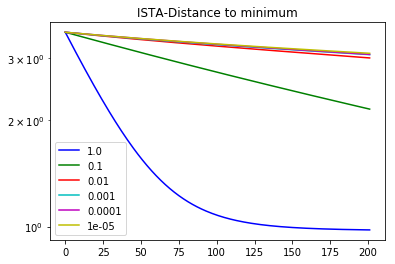

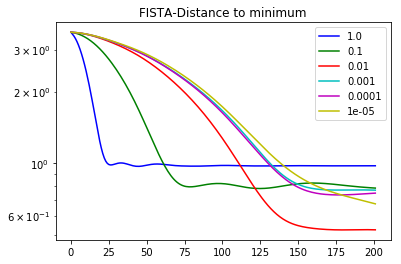

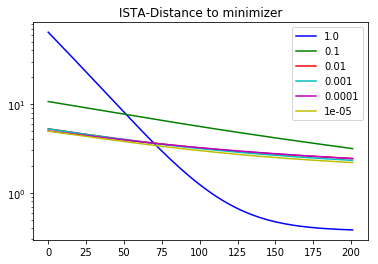

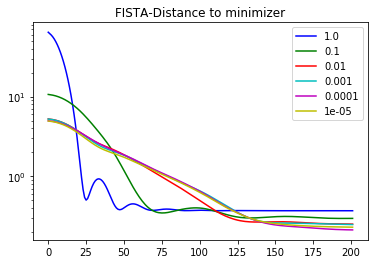

In [26]:
ss = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
colors = "bgrcmyk"
for i, s in enumerate(ss):
    start = time.time()
    A,b = simu_logreg(coefs,corr=corr)
    f = loss_logreg
    grad_f = grad_logreg
    g = ridge
    prox_g = prox_ridge
    step = 1/lip_logreg(A)
    i_x,i_objectives,i_errors = ista(x0, f, grad_f, g, prox_g, step, s=s,x_true=x_min, n_iter=n_iter)
    f_x,f_objectives,f_errors = fista(x0, f, grad_f, g, prox_g, step, s=s,x_true=x_min, n_iter=n_iter)
    l = [norm(i_objective - F_objectives[-1])/norm(F_objectives[-1]) for i_objective in i_objectives]
    m = [norm(f_objective - F_objectives[-1])/norm(F_objectives[-1]) for f_objective in f_objectives]
    plt.figure(1)
    plt.plot(i_errors,colors[i],label=str(s))
    plt.figure(2)
    plt.plot(f_errors,colors[i],label=str(s))
    plt.figure(3)
    plt.plot(l,colors[i],label=str(s))
    plt.figure(4)
    plt.plot(m,colors[i],label=str(s))
    

for fig,name in enumerate(["ISTA-Distance to minimum","FISTA-Distance to minimum","ISTA-Distance to minimizer","FISTA-Distance to minimizer"]):
    plt.figure(fig+1)
    plt.legend()
    plt.title(name)
    plt.yscale('log')

for Ridge penalization:
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.71e+01 | 3.54e+00
     100 | 5.76e+00 | 2.90e+00
     200 | 4.04e+00 | 2.57e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.71e+01 | 3.54e+00
     100 | 6.34e-01 | 6.68e-01
     200 | 5.04e-01 | 3.59e-01
calculation time for ISTA:0.891507625579834
calculation time for FISTA:0.8848996162414551
for Lasso penalization:
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 2.82e+01 | 3.54e+00
     100 | 5.54e+00 | 2.93e+00
     200 | 3.86e+00 | 2.63e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 2.82e+01 | 3.54e+00
     100 | 6.85e-01 | 9.03e-01
     200 | 4.78e-01 | 3.28e-01
calculation time for ISTA:1.0137584209442139
calculation time for FISTA:1.0245084762573242


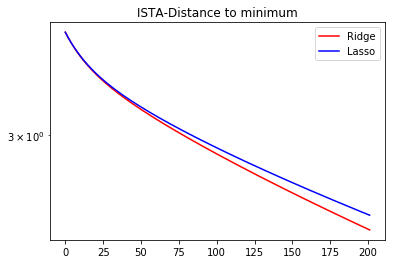

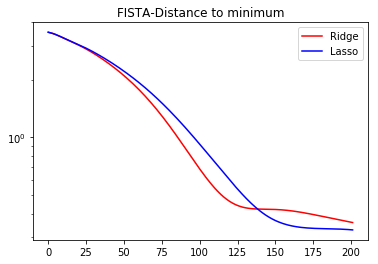

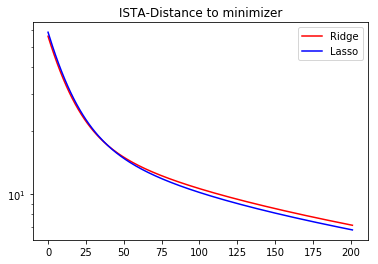

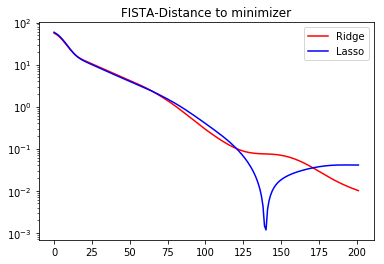

In [27]:
pens = [('Ridge',ridge,prox_ridge), ('Lasso',lasso,prox_lasso)]
colors = "rby"
for i, (name,pen,prox_pen) in enumerate(pens):
    s = 1e-4
    print("for "+name+" penalization:")
    A,b = simu_linreg(coefs,corr=corr)
    f = loss_linreg
    grad_f = grad_linreg
    g = ridge
    prox_g = prox_ridge
    step = 1/lip_linreg(A)
    start = time.time()
    i_x,i_objectives,i_errors = ista(x0, f, grad_f, g, prox_g, step,x_true=x_min, s=s, n_iter=n_iter)
    end1 = time.time()
    f_x,f_objectives,f_errors = fista(x0, f, grad_f, g, prox_g, step,x_true=x_min, s=s, n_iter=n_iter)
    end2 = time.time()
    print("calculation time for ISTA:"+str(end1-start))
    print("calculation time for FISTA:"+str(end2-end1))
    l = [norm(i_objective - F_objectives[-1])/norm(F_objectives[-1]) for i_objective in i_objectives]
    m = [norm(f_objective - F_objectives[-1])/norm(F_objectives[-1]) for f_objective in f_objectives]
    plt.figure(1)
    plt.plot(i_errors,colors[i],label=name)
    plt.figure(2)
    plt.plot(f_errors,colors[i],label=name)
    plt.figure(3)
    plt.plot(l,colors[i],label=name)
    plt.figure(4)
    plt.plot(m,colors[i],label=name)
    

for fig,name in enumerate(["ISTA-Distance to minimum","FISTA-Distance to minimum","ISTA-Distance to minimizer","FISTA-Distance to minimizer"]):
    plt.figure(fig+1)
    plt.legend()
    plt.title(name)
    plt.yscale('log')